# Access-Control Logic

**Purpose:**  
This notebook implements the final decision step of our vehicle access control pipeline. We:

1. **Define** an “allowed plates” list (from a CSV file).  
2. **Load** our trained YOLOv8 + Tesseract OCR pipeline to extract plate text.  
3. **Clean & compare** each OCR’d plate against the allow-list.  
4. **Display** for each test image:
   - The cropped plate region.  
   - The OCR result.  
   - A clear **✅ Access Granted** or **❌ Access Denied** verdict.

By the end of this notebook, you’ll have verified that only permitted vehicles (as specified in your CSV) are granted entry.  

In [2]:
!pip install pytesseract
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [20]:
import os, shutil, pandas as pd

data_dir = '/content/drive/MyDrive/project455/data'
csv_path = os.path.join(data_dir, 'allowed_plates.csv')

if os.path.isdir(csv_path):
    print(f"⚠️  {csv_path} is a directory. Removing it to create a proper CSV file.")
    shutil.rmtree(csv_path)

# Now create a sample CSV
allowed_list = [
    'KAD3HN9993',
    'MH 02 N 1115',
    'DLC AN5398',
    'KA04JO5657',
    'AP 10 BB 3651',
    'DL 3C BS 0440',
    'AP 09 CL 6815',
    'MH02BP2897',
    # … add all your permitted plate numbers here …
]

df_allowed = pd.DataFrame({'plate_number': allowed_list})
df_allowed.to_csv(csv_path, index=False)
print(f"Created {csv_path} with {len(allowed_list)} entries.")

Created /content/drive/MyDrive/project455/data/allowed_plates.csv with 8 entries.


In [21]:
# Imports & model re-load
import os, re
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import pytesseract
from ultralytics import YOLO

# reload your trained YOLOv8 model
model = YOLO('/content/drive/MyDrive/project455/model/yolov8_license_plate_model.pt')

Re-define the OCR helper from Notebook 2


In [22]:
def ocr_variants(crop):
    variants = []
    variants.append((crop, '--psm 11'))
    gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
    _, th = cv2.threshold(gray, 0, 255,
                          cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    variants.append((th, '--psm 7'))
    adapt = cv2.adaptiveThreshold(
        gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,11,2
    )
    variants.append((adapt, '--psm 6'))

    best = ""
    for img, cfg in variants:
        cfg_full = (f"{cfg} --oem 3 "
                    "-c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789")
        txt = pytesseract.image_to_string(img, config=cfg_full).strip()
        if len(txt) > len(best):
            best = txt
    return best

def detect_and_ocr_all(img_path, conf=0.2, pad=5):
    img     = cv2.imread(img_path)
    h, w    = img.shape[:2]
    results = model.predict(img_path, conf=conf, verbose=False)[0]
    outputs = []
    for box in results.boxes.xyxy.cpu().numpy():
        x1,y1,x2,y2 = map(int, box)
        x1, y1 = max(0, x1-pad), max(0, y1-pad)
        x2, y2 = min(w, x2+pad), min(h, y2+pad)
        crop = img[y1:y2, x1:x2]
        txt  = ocr_variants(crop)
        outputs.append((crop, txt))
    return outputs

Load the allowed-plates list

In [23]:
csv_path = '/content/drive/MyDrive/project455/data/allowed_plates.csv'
df       = pd.read_csv(csv_path)
allowed  = (
    df['plate_number']
      .astype(str)
      .str.replace(r'[^A-Za-z0-9]', '', regex=True)
      .str.upper()
      .tolist()
)
print(f"🔓 Loaded {len(allowed)} allowed plates from:\n  {csv_path}")

🔓 Loaded 8 allowed plates from:
  /content/drive/MyDrive/project455/data/allowed_plates.csv


Verification function + sanity check

In [24]:
def verify_plate(text):
    key = re.sub(r'[^A-Z0-9]', '', text.upper())
    return key in allowed

# quick test
for sample in ['MH 02 N 1115','MH 44 D 3','DLC AN5398','KA04JO5657','DL8C W 0587']:
    print(f"{sample} →", "GRANTED" if verify_plate(sample) else "DENIED")

MH 02 N 1115 → GRANTED
MH 44 D 3 → DENIED
DLC AN5398 → GRANTED
KA04JO5657 → GRANTED
DL8C W 0587 → DENIED


End-to-end on a few test images


=== 00000002.jpg ===


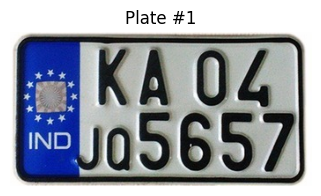

OCR: 
❌ Access Denied



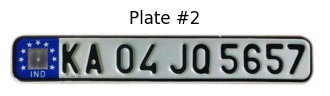

OCR: KA04JO5657
✅ Access Granted


=== License (1207).png ===


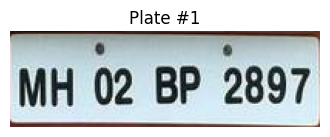

OCR: MH02BP2897
✅ Access Granted


=== License (1404).png ===


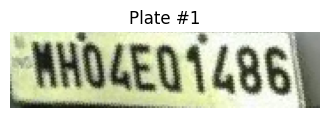

OCR: PANOLENTLRS
❌ Access Denied



In [27]:
test_dir  = '/content/drive/MyDrive/project455/datasets/test'
exts      = ('.png','.jpg','.jpeg')
test_imgs = sorted(f for f in os.listdir(test_dir)
                   if f.lower().endswith(exts))

# pick some indices to inspect
for idx in [0, 137, 210]:
    fname  = test_imgs[idx]
    path   = os.path.join(test_dir, fname)
    plates = detect_and_ocr_all(path)

    print(f"\n=== {fname} ===")
    if not plates:
        print("❗ No plates detected.\n")
        continue

    for j, (crop, txt) in enumerate(plates, start=1):
        # show the cropped plate
        plt.figure(figsize=(4,2))
        plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f"Plate #{j}")
        plt.show()

        # print OCR & access decision
        status = "✅ Access Granted" if verify_plate(txt) else "❌ Access Denied"
        print(f"OCR: {txt}\n{status}\n")